In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from data_generator import generate_data

from sklearn.neighbors import KNeighborsRegressor

# Data generator

In [2]:
import numpy as np

def sample_u_power(n, k=2, rng=None):
    """
    Sample n values on (0,10) from f(x) ∝ |x-5|^k using rejection sampling.
    k controls how deep the middle valley is (higher k -> lower center prob).
    """
    samples = []
    # envelope max f occurs at edges: |x-5| = 5, so f_max = 5**k (we use ratio f(x)/f_max)
    while len(samples) < n:
        x = rng.random() * 10.0            # candidate from Uniform(0,10)
        u = rng.random()
        accept_prob = (abs(x - 5.0) / 5.0) ** k
        if u < accept_prob:
            samples.append(x)
    return np.array(samples)

def generate_data_luben(n, rng):
    # Proportional number of points for dense and sparse regions
    num_dense = round(0.425 * n)  # half of the data points go to dense regions
    num_middle = round(
        0.15 * n
    )  # a small fraction of data points for the middle region

    # Generate x values for dense and sparse regions
    x_dense1 = rng.uniform(0, 1.5, num_dense)
    x_dense2 = rng.uniform(8, 10, num_dense)
    # using beta
    x_middle = (rng.beta(8, 8, num_middle) * (8 - 1.5)) + 1.5
    x_sparse = np.concatenate([x_dense1, x_dense2, x_middle])

    # True function to generate y based on x
    def true_function(x):
        y = 2 * np.sin(x) + rng.normal(0, 0.1, len(x))
        mask = (2 < x) & (x < 7.5)
        y[mask] += rng.normal(0, 2, np.sum(mask))
        return y

    # Generate y values
    y = true_function(x_sparse)

    # Return as a data frame
    return {"x": x_sparse, "y": y}

def generate_data(n, type='linear', heteroscedastic=False, epistemic_uncertainty=False, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    if type=='luben':
        return generate_data_luben(n, rng)
    
    if type=='butterfly':
        x = rng.normal(5, 2, 1000)
        y = [rng.normal(0, np.abs(i-5)) for i in x]
        return {'x':x, 'y':y}
    
    if epistemic_uncertainty:
        x = sample_u_power(n, 2, rng)
    else:
        x = rng.uniform(0, 10, n)
        
    if type=='quadratic':
        y = [i**2 - 10*i + 25 for i in x]
    elif type=='logistic':
        y = [20 / (1+np.exp(-(i-5))) for i in x]
    elif type=='linear':
        y = x
    
    if heteroscedastic:
        y = [i + rng.normal(0, i/4) for i in y]
    else:
        y = [i + rng.normal(0, 1) for i in y]
    
    return {'x':x, 'y':y}

# Tipos de dados trabalhados

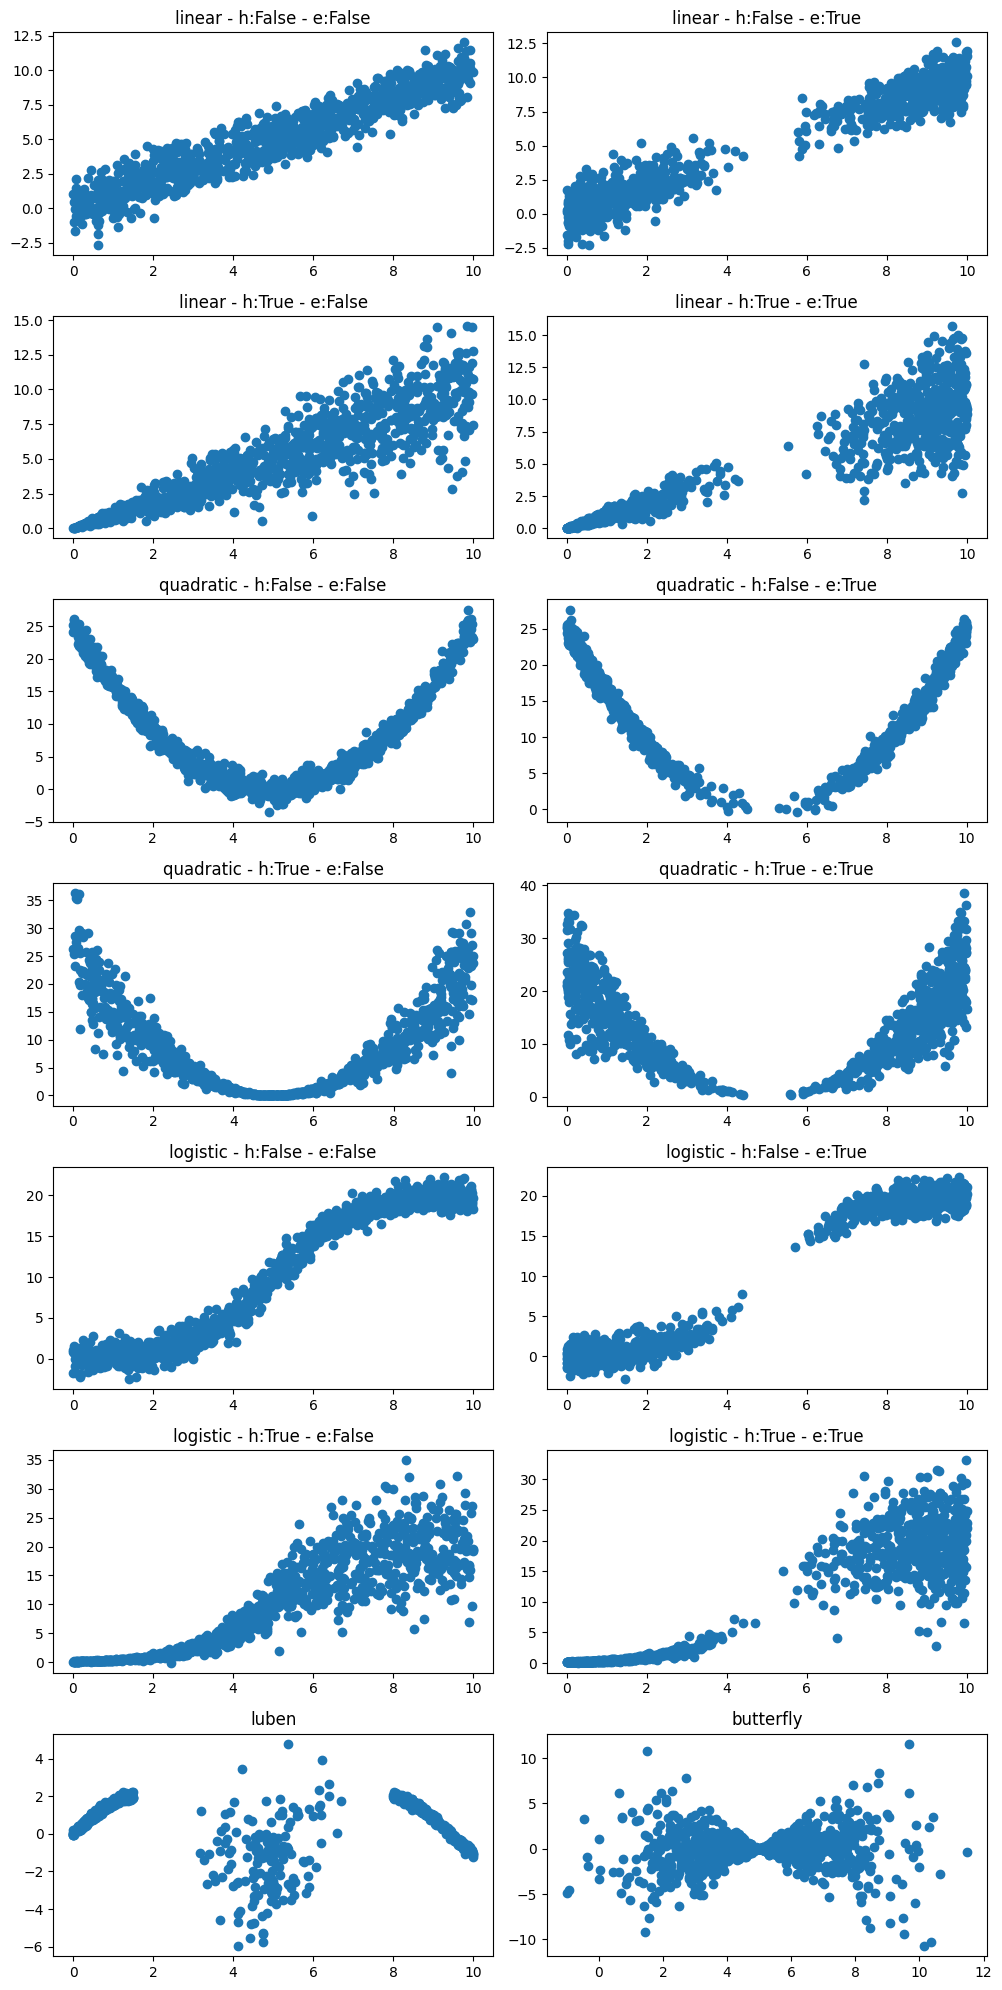

In [3]:
rng = np.random.default_rng(20251205)
plt.figure(figsize=(10, 20))

i = 0
for name_flag in ['linear', 'quadratic', 'logistic']:
    for heteroscedastic_flag in [False, True]:
        for epistemic_flag in [False, True]:
            plt.subplot(7, 2, i+1)
            data = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
            plt.title(f'{name_flag} - h:{heteroscedastic_flag} - e:{epistemic_flag}')
            plt.scatter(data['x'], data['y'])
            i+=1

plt.subplot(7, 2, i+1)
data = generate_data(1000, type='luben')
plt.title(f'luben')
plt.scatter(data['x'], data['y'])

plt.subplot(7, 2, i+2)
data = generate_data(1000, type='butterfly')
plt.title(f'butterfly')
plt.scatter(data['x'], data['y'])

plt.tight_layout()

# Ajuste do modelo base $g$
1) ajustar um modelo bart na loss
1) implementar ideias do paper do Rafael na abstenção de observações

In [4]:
def loss_function(y_pred, y_true):
    return np.abs(y_pred - y_true)

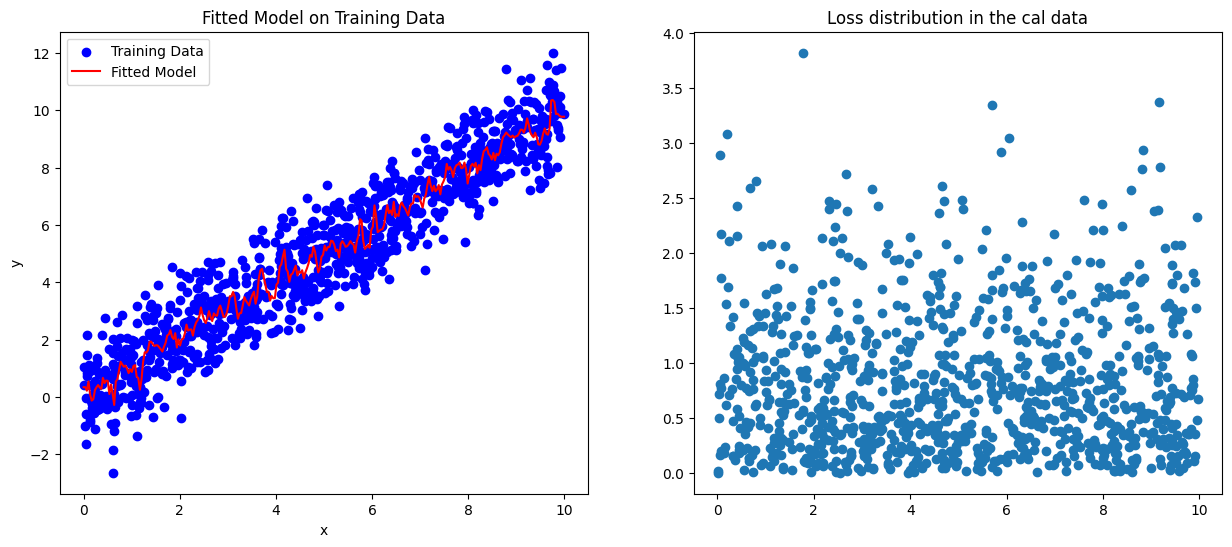

In [5]:
rng = np.random.default_rng(20251205)

name_flag = 'linear'
heteroscedastic_flag = False
epistemic_flag = False

data_train = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
data_cal = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
data_test = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)

# plt.figure(figsize=(10, 4))
# j = 0
# for i in [data_train, data_cal, data_test]:
#     plt.subplot(1, 3, j+1)
#     plt.scatter(i['x'], i['y'])
#     j += 1

X_train, y_train = data_train['x'].reshape(-1, 1), data_train['y']
X_cal, y_cal = data_cal['x'].reshape(-1, 1), data_cal['y']
X_test, y_test = data_test['x'].reshape(-1, 1), data_test['y']

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

x_grid = np.linspace(data_train["x"].min(), data_train["x"].max(), 300).reshape(-1, 1)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_train["x"], data_train["y"], color="blue", label="Training Data")
plt.plot(x_grid, model.predict(x_grid), color="red", label="Fitted Model")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted Model on Training Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss distribution in the cal data')
plt.scatter(X_cal, loss_function(model.predict(X_cal), y_cal))
plt.show()

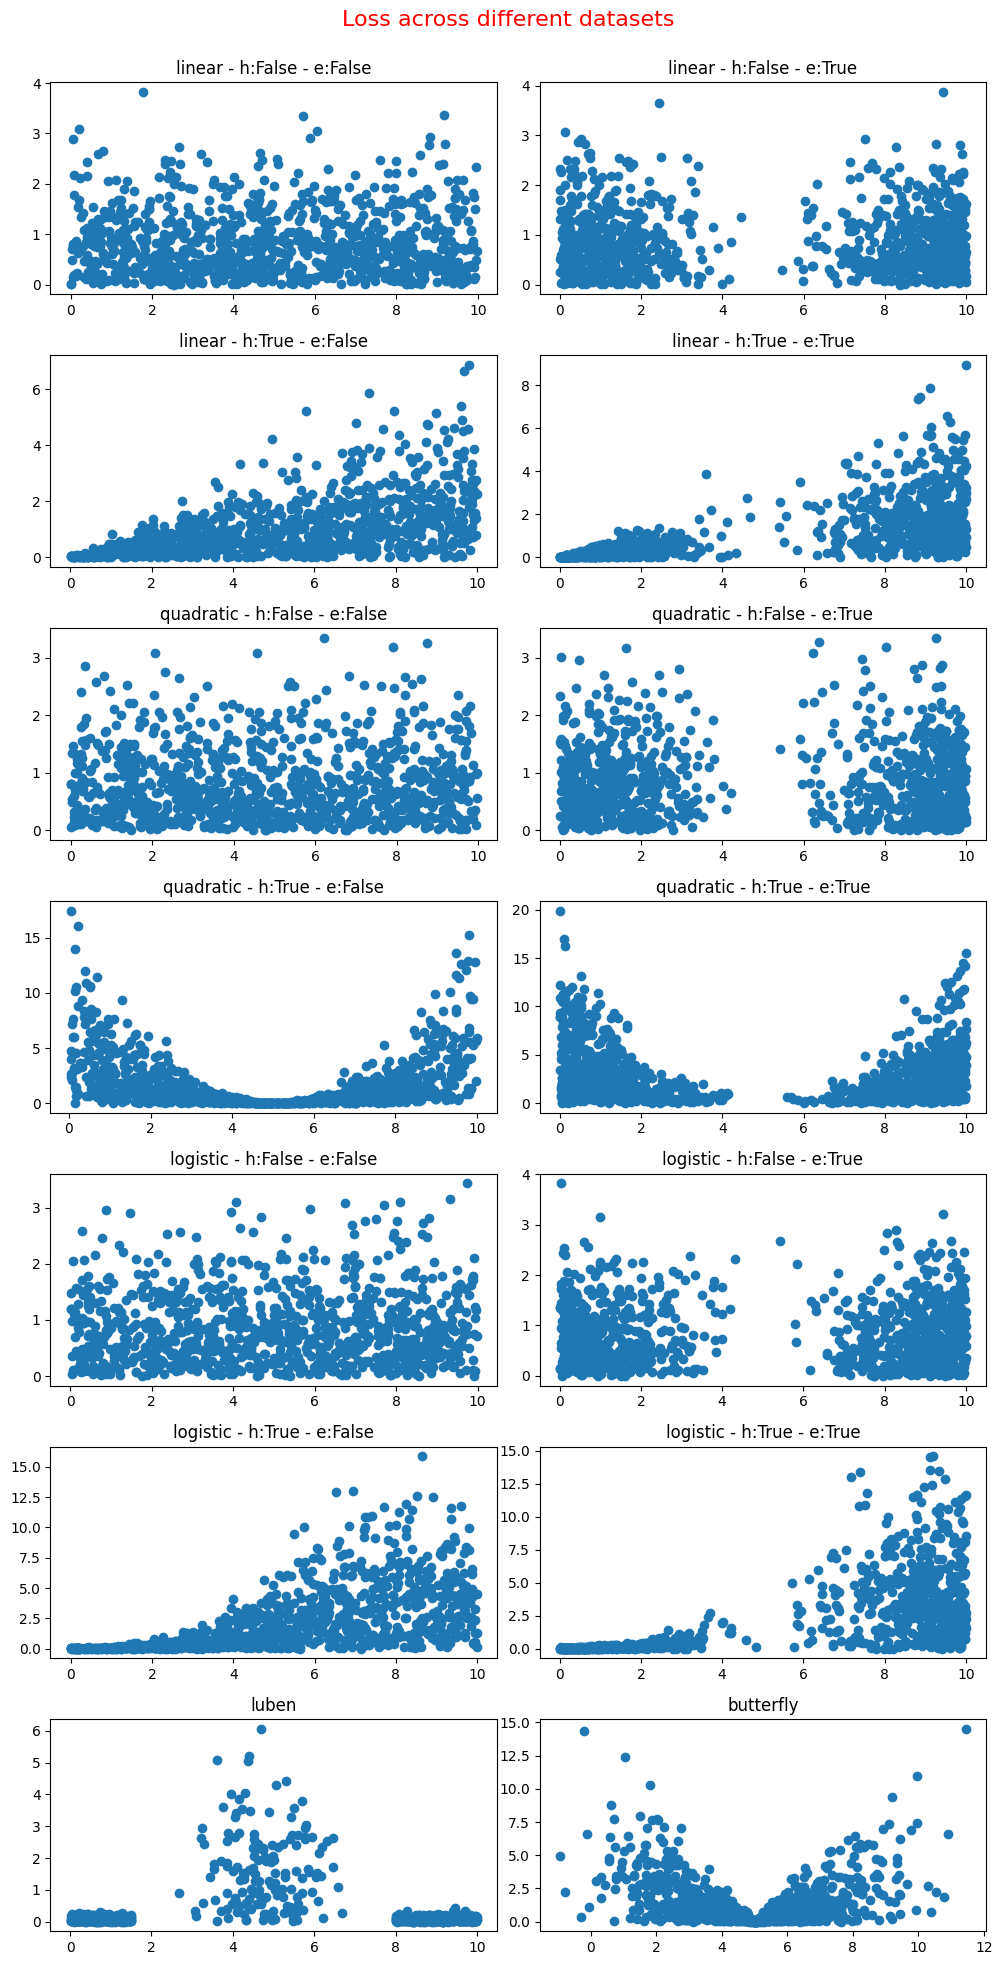

In [6]:
rng = np.random.default_rng(20251205)

plt.figure(figsize=(10, 20))
plt.suptitle('Loss across different datasets', color='red', fontsize=16)

i = 0
for name_flag in ['linear', 'quadratic', 'logistic']:
    for heteroscedastic_flag in [False, True]:
        for epistemic_flag in [False, True]:
            data_train = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
            data_cal = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
            data_test = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)

            X_train, y_train = data_train['x'].reshape(-1, 1), data_train['y']
            X_cal, y_cal = data_cal['x'].reshape(-1, 1), data_cal['y']
            X_test, y_test = data_test['x'].reshape(-1, 1), data_test['y']

            model = KNeighborsRegressor(n_neighbors=10)
            model.fit(X_train, y_train)

            plt.subplot(7, 2, i+1)
            plt.title(f'{name_flag} - h:{heteroscedastic_flag} - e:{epistemic_flag}')
            plt.scatter(X_cal, loss_function(model.predict(X_cal), y_cal))
            i+=1

data_train = generate_data(n=1000, type='luben')
data_cal = generate_data(n=1000, type='luben')
data_test = generate_data(n=1000, type='luben')

X_train, y_train = data_train['x'].reshape(-1, 1), data_train['y']
X_cal, y_cal = data_cal['x'].reshape(-1, 1), data_cal['y']
X_test, y_test = data_test['x'].reshape(-1, 1), data_test['y']

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

plt.subplot(7, 2, i+1)
plt.title('luben')
plt.scatter(X_cal, loss_function(model.predict(X_cal), y_cal))

data_train = generate_data(n=1000, type='butterfly')
data_cal = generate_data(n=1000, type='butterfly')
data_test = generate_data(n=1000, type='butterfly')

X_train, y_train = data_train['x'].reshape(-1, 1), data_train['y']
X_cal, y_cal = data_cal['x'].reshape(-1, 1), data_cal['y']
X_test, y_test = data_test['x'].reshape(-1, 1), data_test['y']

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

plt.subplot(7, 2, i+2)
plt.title('butterfly')
plt.scatter(X_cal, loss_function(model.predict(X_cal), y_cal))

plt.tight_layout(rect=[0, 0, 1, 0.98])

# Ajusta a predição para a incerteza $Z$

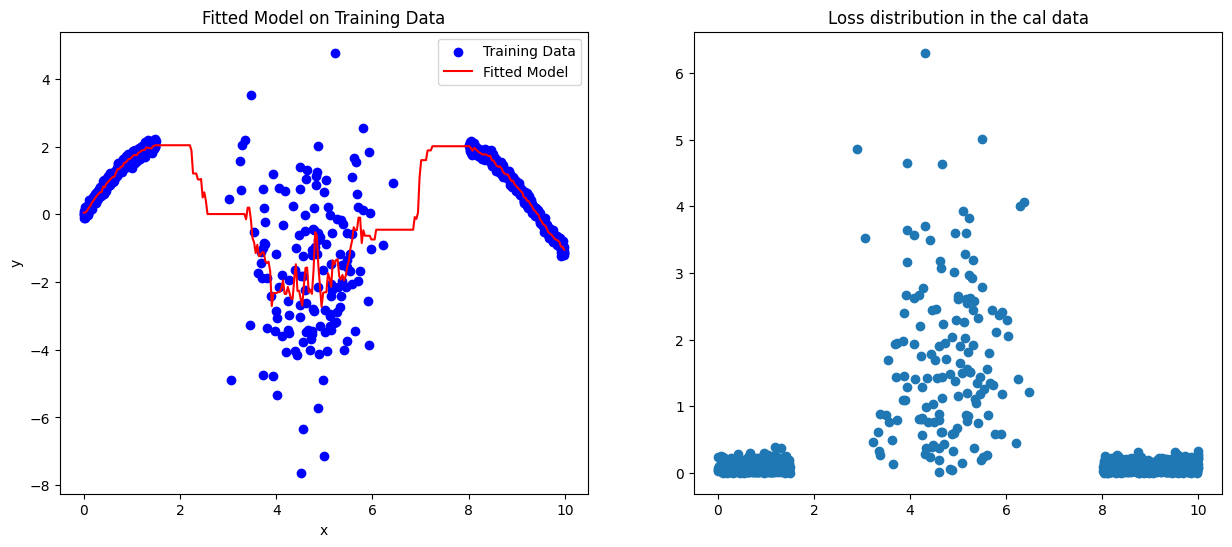

In [7]:
rng = np.random.default_rng(20251205)

name_flag = 'luben'
heteroscedastic_flag = False
epistemic_flag = False

data_train = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
data_cal = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)
data_test = generate_data(n=1000, type=name_flag, heteroscedastic=heteroscedastic_flag, epistemic_uncertainty=epistemic_flag, rng=rng)

# plt.figure(figsize=(10, 4))
# j = 0
# for i in [data_train, data_cal, data_test]:
#     plt.subplot(1, 3, j+1)
#     plt.scatter(i['x'], i['y'])
#     j += 1

X_train, y_train = data_train['x'].reshape(-1, 1), data_train['y']
X_cal, y_cal = data_cal['x'].reshape(-1, 1), data_cal['y']
X_test, y_test = data_test['x'].reshape(-1, 1), data_test['y']

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

x_grid = np.linspace(data_train["x"].min(), data_train["x"].max(), 300).reshape(-1, 1)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_train["x"], data_train["y"], color="blue", label="Training Data")
plt.plot(x_grid, model.predict(x_grid), color="red", label="Fitted Model")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted Model on Training Data")
plt.legend()

z_obs = loss_function(model.predict(X_cal), y_cal)
plt.subplot(1, 2, 2)
plt.title('Loss distribution in the cal data')
plt.scatter(X_cal, z_obs)
plt.show()

## Roda o BART

In [8]:
import pymc as pm
import pymc_bart as pmb
from pymc_bart.split_rules import ContinuousSplitRule, OneHotSplitRule
import arviz as az
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

In [9]:
split_types = np.repeat(ContinuousSplitRule, repeats=X_cal.shape[1])
split_types = split_types.tolist()
n_sample = 2000

with pm.Model() as model_bart:
    w = pmb.BART( "w", X_cal, z_obs, m=100, shape=(2, X_cal.shape[0]))
    # y = pm.Normal("y", w[0], np.exp(w[1]), observed=z_obs, shape=X_cal.shape[0])
    y = pm.Gamma("y", mu=pm.math.exp(w[0]), sigma=pm.math.exp(w[1]), observed=z_obs)

In [10]:
with model_bart:
    mc_sample = pm.sample(n_sample, chains=4, random_seed=rng, cores=6, progressbar=False)
    posterior_predictive_test = pm.sample_posterior_predictive(trace=mc_sample, random_seed=rng, predictions=False, progressbar=False)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 403 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


In [11]:
posterior_mean = mc_sample.posterior["w"].mean(dim=("chain", "draw"))[0]
w_hdi = az.hdi(ary=mc_sample, group="posterior", var_names=["w"], hdi_prob=0.5)
pps = az.extract(posterior_predictive_test, group="posterior_predictive", var_names=["y"]).T

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


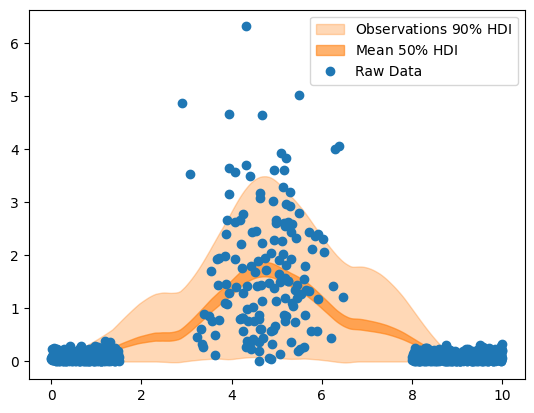

In [12]:
idx = np.argsort(X_cal[:, 0])

fig, ax = plt.subplots()
az.plot_hdi(
    x=X_cal[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.90,
    fill_kwargs={"alpha": 0.3, "label": r"Observations $90\%$ HDI"},
)
az.plot_hdi(
    x=X_cal[:, 0],
    hdi_data=np.exp(w_hdi["w"].sel(w_dim_0=0)),
    ax=ax,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $50\%$ HDI"},
)
ax.plot(X_cal, z_obs, "o", c="C0", label="Raw Data")
ax.legend(loc="upper right")